## Exploring Dask
Dask is a better framework for data frame, and can be used for huge data

In [99]:
import dask
import numpy as np
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client
#Importing plot lib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
sns.set(rc={'figure.figsize':(20, 10)})
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [100]:
# Creating distributed client
client = Client()

/Users/anoronha/opt/anaconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [101]:
df = dd.read_csv('june*')
print (df)

Dask DataFrame Structure:
                 2016-06-01 00:05:01   39.364 211.62.96.220 42.219.158.212  55107  64188     UDP  .A....      0    0.1     19   3958 background
npartitions=3889                                                                                                                               
                              object  float64        object         object  int64  int64  object  object  int64  int64  int64  int64     object
                                 ...      ...           ...            ...    ...    ...     ...     ...    ...    ...    ...    ...        ...
...                              ...      ...           ...            ...    ...    ...     ...     ...    ...    ...    ...    ...        ...
                                 ...      ...           ...            ...    ...    ...     ...     ...    ...    ...    ...    ...        ...
                                 ...      ...           ...            ...    ...    ...     ...     ...    ..

In [102]:
df.columns=['te','td','sa','da','sp','dp','pr','flg','fwd','stos','pkt','byt','label']

In [103]:
df.head(10)

,te,td,sa,da,sp,dp,pr,flg,fwd,stos,pkt,byt,label
0,2016-06-01 00:05:03,39.828,42.219.158.226,71.247.111.184,80,52475,TCP,.AP.S.,0,0,57,79635,background
1,2016-06-01 00:05:04,36.128,42.219.153.155,223.80.226.127,443,54691,TCP,.AP.S.,0,0,9,2791,background
2,2016-06-01 00:05:04,36.204,223.80.226.127,42.219.153.155,54691,443,TCP,.AP.S.,0,0,13,3896,background
3,2016-06-01 00:05:04,42.452,42.219.153.7,42.187.82.40,53,53,UDP,.A....,0,0,2,175,background
4,2016-06-01 00:05:06,36.968,42.219.153.89,143.72.8.137,63532,53,UDP,.A....,0,0,3,233,background
5,2016-06-01 00:05:06,36.992,143.72.8.137,42.219.153.89,53,63532,UDP,.A....,0,0,3,281,background
6,2016-06-01 00:05:06,38.172,240.177.183.143,42.219.155.59,443,62402,TCP,.AP...,0,0,2,82,background
7,2016-06-01 00:05:06,40.648,42.219.155.59,52.76.101.190,42776,22163,UDP,.A....,0,0,4,275,background
8,2016-06-01 00:05:07,176.320,42.219.153.89,92.225.32.126,61846,443,TCP,.AP...,0,0,5,2220,background
9,2016-06-01 00:05:07,176.532,92.225.32.126,42.219.153.89,443,61846,TCP,.AP...,0,0,10,2070,background


In [104]:
# Keeping a copy
data = df

In [105]:
# Changing column data type for te
data['te'] = dd.to_datetime(df['te'])

In [106]:
# Function to mark traffic has anomalous data when windowing
normal_traffic_type = ['background', 'blacklist']
def isAnomolus(x):
    data = ~x.isin(normal_traffic_type)
    if data.any():
        return 1
    else:
        return 0

In [107]:
# Function to mark traffic has anomalous data when windowing
normal_traffic_type = ['background', 'blacklist']
def isAnomolus_new(x):
    return x

In [108]:
isAnomolus_agg = dd.Aggregation(
    name = 'isAnomolus',
    chunk = lambda x: x.apply(lambda a: (~a.isin(normal_traffic_type)).any()),
    agg = lambda y: y.apply(lambda z: 1 if z.any() == True else 0)
)

In [109]:
# Data windowed for 5 min by adding pkt and byt, whreas label and true if any anomalous traffic exists in time window
data_win = data.groupby(pd.Grouper(key='te', freq='5T')).agg({
                                        "pkt":  "sum",
                                        "byt":  "sum",
                                        "label": isAnomolus_agg
                                    }).compute()

In [110]:
data_win

,pkt,byt,label
te,,,
2016-06-01 00:05:00,9137379,5169739889,0
2016-06-01 00:10:00,12126441,8373608719,0
2016-06-01 00:15:00,13050846,9565382340,0
2016-06-01 00:20:00,11543577,8782554929,0
2016-06-01 00:25:00,11745197,8282543104,0
...,...,...,...
2016-06-19 23:45:00,10060280,7509134140,0
2016-06-19 23:50:00,10186994,7988324627,0
2016-06-19 23:55:00,10492758,7854031444,0


In [111]:
data_win_anomaly = data_win[data_win['label'] == 1]

In [112]:
data_win_anomaly

,pkt,byt,label
te,,,
2016-06-01 00:40:00,11039625,7775423444,1
2016-06-01 06:30:00,11205790,8561739376,1
2016-06-01 19:05:00,13542549,9307064345,1
2016-06-01 19:50:00,9985508,7346964854,1
2016-06-02 03:15:00,9867259,6778283798,1
...,...,...,...
2016-06-19 12:40:00,7221752,5038390658,1
2016-06-19 16:20:00,5865303,3502920269,1
2016-06-19 16:50:00,6909186,4505250180,1


### Taking only normal traffic(including blacklisted) 
The idea is to forecats the normal traffic, and compare with anomalous traffic for any deviation. Hence getting normal traffic windowed for each 5min which will be used for forecasting.

In [113]:
# Filter normal traffic
data_normal_traffic = data[data['label'].isin(normal_traffic_type)] 

In [114]:
# Window normal traffic for 5min window
data_normal_traffic_win = data_normal_traffic.groupby(pd.Grouper(key='te', freq='5T')).agg({
                                        "pkt":  "sum",
                                        "byt":  "sum"
                                    }).compute()

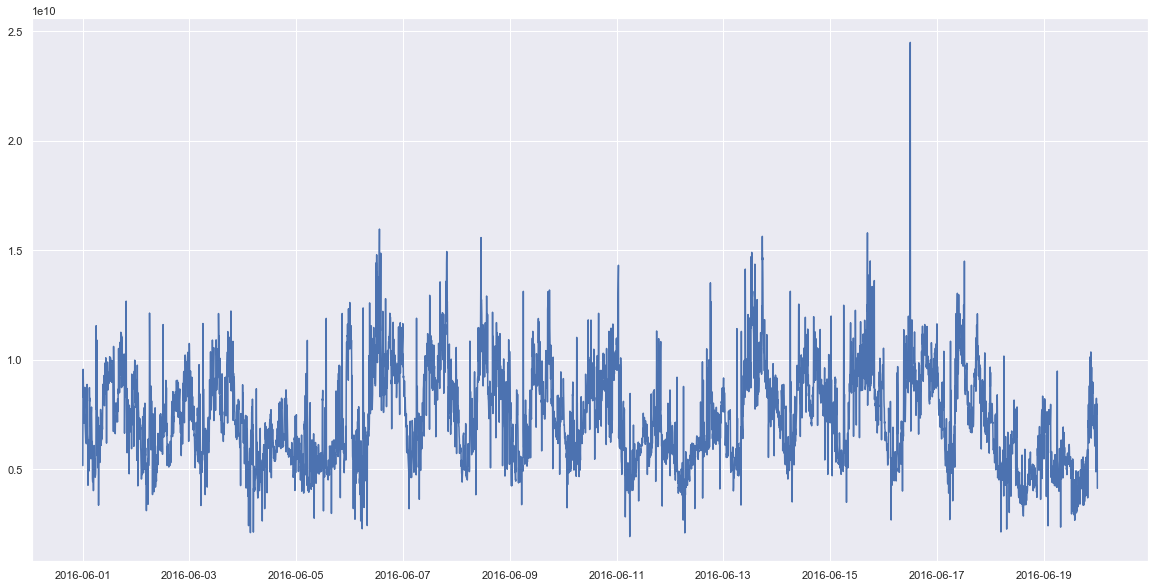

In [115]:
plt.figure()
plt.plot(data_normal_traffic_win.index, data_normal_traffic_win.byt)
plt.show()
plt.close()

In [116]:
merged_data = pd.merge(data_win, data_normal_traffic_win, on=['te'], how='inner')

In [117]:
merged_data['byt_diff'] = merged_data.byt_x - merged_data.byt_y

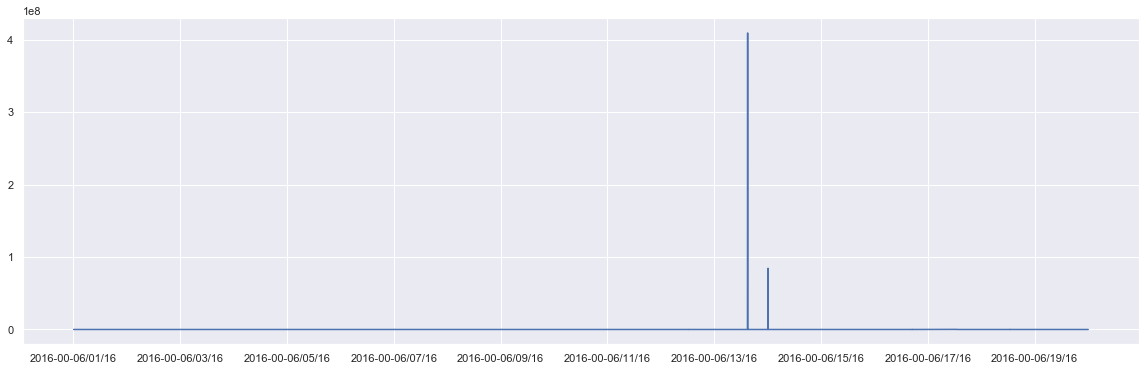

In [118]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))
myFmt = mdates.DateFormatter('%Y-%M-%D')
ax.xaxis.set_major_formatter(myFmt)
ax.plot(merged_data.byt_diff, label='Difference')
plt.show()
plt.close()

In [119]:
plt.close()

### EDA for windowed data

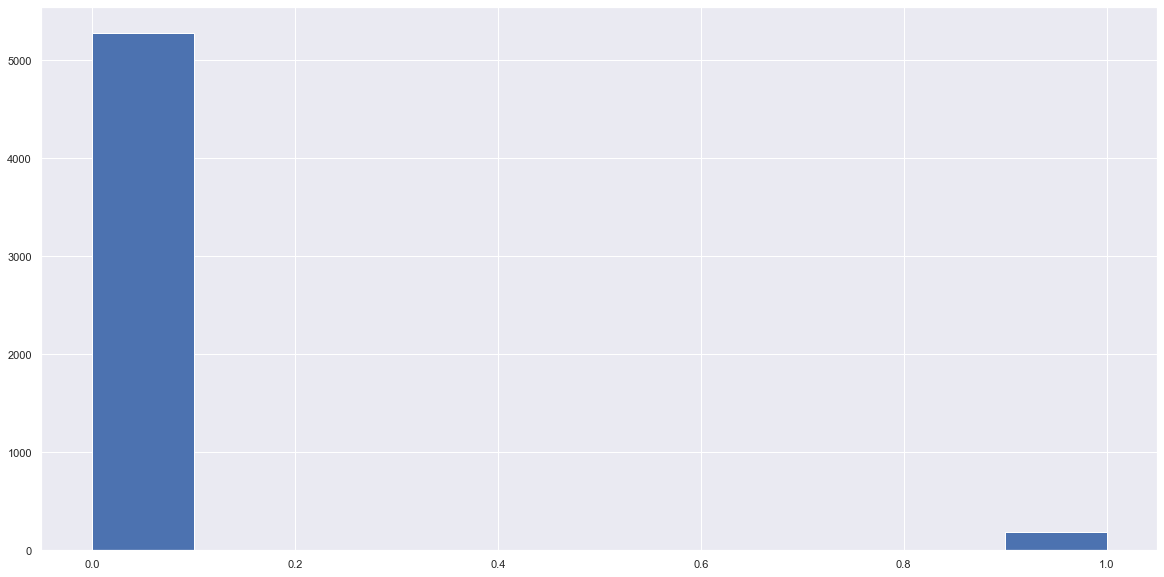

In [120]:
plt.hist(data_win.label)
plt.show()
plt.close()

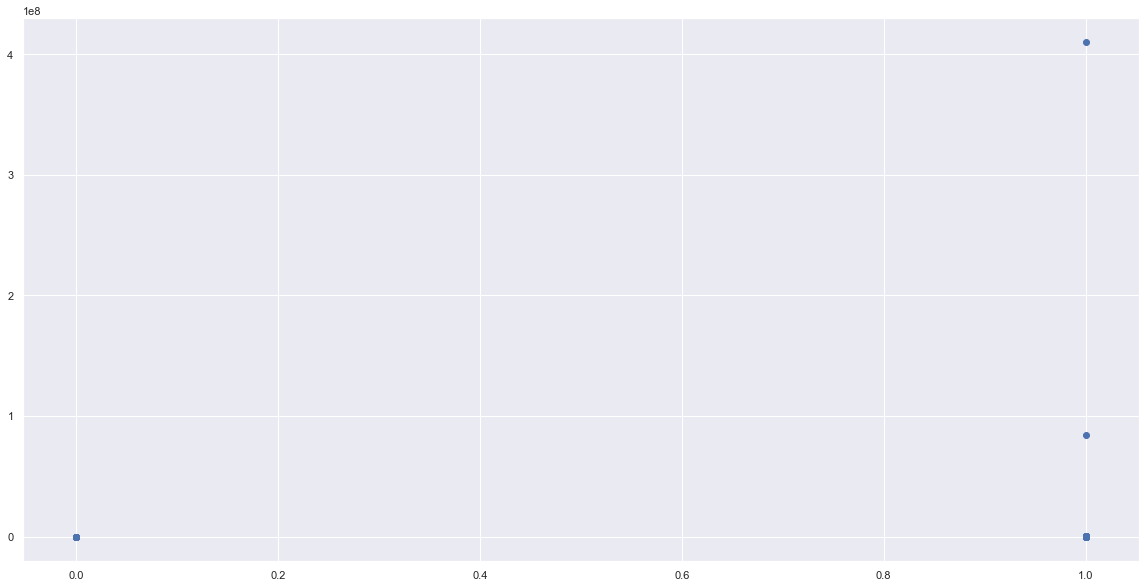

In [121]:
plt.scatter(merged_data.label, merged_data.byt_diff)
plt.show()
plt.close()

In [122]:
merged_data[(merged_data.byt_diff == 0) & (merged_data.label == 1)].count()

pkt_x       0
byt_x       0
label       0
pkt_y       0
byt_y       0
byt_diff    0
dtype: int64

In [123]:
merged_data[merged_data.byt_diff !=0].byt_diff.nsmallest(40)

te
2016-06-14 21:10:00    40
2016-06-18 15:25:00    40
2016-06-01 00:40:00    80
2016-06-01 06:30:00    80
2016-06-05 18:30:00    80
2016-06-06 19:05:00    80
2016-06-09 23:15:00    80
2016-06-10 01:25:00    80
2016-06-01 19:05:00    84
2016-06-04 20:30:00    84
2016-06-15 22:05:00    84
2016-06-15 23:40:00    84
2016-06-16 18:05:00    84
2016-06-16 19:20:00    84
2016-06-16 19:45:00    84
2016-06-17 05:25:00    84
2016-06-17 15:00:00    84
2016-06-17 16:20:00    84
2016-06-17 19:40:00    84
2016-06-17 20:25:00    84
2016-06-18 07:30:00    84
2016-06-18 08:15:00    84
2016-06-18 14:50:00    84
2016-06-18 15:40:00    84
2016-06-18 22:40:00    84
2016-06-19 08:00:00    84
2016-06-19 10:35:00    84
2016-06-19 16:20:00    84
2016-06-05 19:30:00    88
2016-06-05 19:40:00    88
2016-06-05 19:50:00    88
2016-06-05 20:10:00    88
2016-06-05 20:35:00    88
2016-06-05 22:35:00    88
2016-06-05 22:40:00    88
2016-06-05 23:15:00    88
2016-06-05 23:55:00    88
2016-06-06 00:25:00    88
2016-06-0

In [124]:
data['anomaly'] = data['label'].apply(lambda x: 0 if x in(normal_traffic_type) else 1)

/Users/anoronha/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/core.py:2957: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('label', 'int64'))

  warnings.warn(meta_warning(meta))


In [125]:
protocols = ['TCP', 'UDP', 'ICMP', 'GRE', 'ESP', 'RSVP', 'IPv6', 'IPIP', '255','nan']
data['protocol'] = data['pr'].apply(lambda x: protocols.index(x) if x in protocols else -1)

/Users/anoronha/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/core.py:2957: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('pr', 'int64'))

  warnings.warn(meta_warning(meta))


In [126]:
#data['pr'].unique().compute()

In [127]:
#data['flg'].unique().compute()

In [128]:
plt.close()

## ARIMA model forecasting

In [129]:
result = adfuller(data_normal_traffic_win.byt, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 

ADF Statistic: -6.534271960320292
n_lags: 9.696409141549907e-09
p-value: 9.696409141549907e-09
Critial Values:
   1%, -3.431551098654962
Critial Values:
   5%, -2.8620707653126733
Critial Values:
   10%, -2.567052525371161


In [130]:
# Original Series and taking byt as value
fig1, axes1 = acfplt.subplots(3, 2, sharex=True)
axes1[0, 0].plot(data_normal_traffic_win.byt); axes1[0, 0].set_title('Original Series')
plot_acf(data_normal_traffic_win.byt.squeeze(),  lags=np.arange(len(data_normal_traffic_win)) , ax=axes1[0, 1])

# 1st Differencing
axes1[1, 0].plot(data_normal_traffic_win.byt.diff()); axes1[1, 0].set_title('1st Order Differencing')
#plot_acf(data_normal_traffic_win.byt.diff().dropna(), lags=np.arange(len(data_normal_traffic_win) -2), ax=axes1[1, 1])

# 2nd Differencing
axes1[2, 0].plot(data_normal_traffic_win.byt.diff().diff()); axes1[2, 0].set_title('2nd Order Differencing')
#plot_acf(data_normal_traffic_win.byt.diff().diff().dropna(), lags=np.arange(len(data_normal_traffic_win) - 3), ax=axes1[2, 1])
acfplt.show()


ValueError: view limit minimum -36806.750173611115 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 1440x720 with 6 Axes>

In [131]:
print(data_normal_traffic_win.index.freq)

None
